In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from rdkit import Chem
from rdkit.Chem import Draw


matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 144

In [7]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple. 

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df['r_i_docking_score'] = pd.to_numeric(df['r_i_docking_score'], errors='coerce')

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df['r_i_docking_score'].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}")

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=['r_i_docking_score'])

    # Convert 'r_i_docking_score' to int64
    df['r_i_docking_score'] = df['r_i_docking_score'].astype('float64')

    return df

In [8]:
active=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))
decoy=sdf_to_df(("./ADRB1/docking/ADRB1_decoy_docking_lib.sdf", "inactive"))

In [9]:
duplicates = decoy[decoy.duplicated('Molecule_Name', keep=False)]
display(duplicates)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty
85,C04176600_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x127227bc0>,0,ADRB1_chembl19_set_decoy_sc.smi,10099,53161,0,S-OPLS,30.7602,1,C04176600_Isomer1-1,ADRB1,10098,6,-8.99968,-0.321417,-0.976012,-2.07739,-8.99968,-3.79092,-0.0278181,-0,-2.1832,-44.1743,-8.3662,0.504739,-0.038832,-81.3076,-52.5405,5.69805,7,281,0
221,C23580577_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2aa8dae30>,0,ADRB1_chembl19_set_decoy_sc.smi,4030,53161,0,S-OPLS,36.1635,1,C23580577_Isomer2-1,ADRB1,4029,8,-8.58907,-0.318114,-0.954341,-1.99939,-8.58907,-3.90289,-0.187131,-0,-1.71363,-40.8158,-9.11162,0.712986,-0.0908786,-85.7881,-49.9274,3.34068,56,80,0
291,C23259756_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2aa8e0d60>,0,ADRB1_chembl19_set_decoy_sc.smi,2998,53161,0,S-OPLS,42.9523,1,C23259756_Isomer1-1,ADRB1,2997,9,-8.46557,-0.256532,-0.822836,-1.8827,-8.46557,-3.36221,-0.32,-0,-1.16017,-54.2617,-10.2764,0.691707,-0.0603416,-98.2976,-64.5381,10.9211,30,86,0
329,C23580577_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2aa8e1e00>,0,ADRB1_chembl19_set_decoy_sc.smi,4029,53161,0,S-OPLS,36.2908,1,C23580577_Isomer1-1,ADRB1,4028,8,-8.41108,-0.311521,-0.934564,-1.95796,-8.41108,-3.34526,-0.167232,-0,-1.75708,-41.2313,-11.2862,0.712986,-0.1,-87.9926,-52.5175,3.47627,155,232,0
464,C14979644_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2aa8ed9a0>,0,ADRB1_chembl19_set_decoy_sc.smi,5455,53161,0,S-OPLS,20.1198,1,C14979644_Isomer1-1,ADRB1,5454,9,-8.26129,-0.393395,-1.08535,-2.04259,-8.26129,-2.26797,-0.484938,-0,-1.29946,-32.5677,-21.0785,0.801329,-0.22008,-85.086,-53.6463,6.20167,130,262,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11185,C53248445_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2bd3155b0>,0,ADRB1_chembl19_set_decoy_sc.smi,2627,53161,0,S-OPLS,42.1512,1,C53248445_Isomer2-1,ADRB1,2626,8,-3.96824,-0.198412,-0.538573,-0.99312,-3.96824,-0.551295,-0.576234,-0,-2.23197,-26.5151,-9.01442,2.16917,-0.1,-44.8285,-35.5295,6.66799,95,365,0
11249,C40759579_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2bd3171b0>,0,ADRB1_chembl19_set_decoy_sc.smi,7070,53161,0,S-OPLS,35.8384,1,C40759579_Isomer1-1,ADRB1,7069,10,-3.86917,-0.138184,-0.41961,-0.893117,-3.86917,-1.08174,-0.32,-0,-0.623732,-42.3811,-2.72151,0.825551,-0.141966,-46.531,-45.1026,13.3377,67,329,0
11307,C53248445_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2bd358ba0>,0,ADRB1_chembl19_set_decoy_sc.smi,2626,53161,0,S-OPLS,39.7293,1,C53248445_Isomer1-1,ADRB1,2625,8,-3.74586,-0.187293,-0.508391,-0.937465,-3.74586,-1.70803,-0.56879,-0,-1.97787,-24.801,-8.78568,3.09881,-0.0320837,-40.7466,-33.5866,5.4371,119,153,0
11531,C79077325_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2bd39ee30>,0,ADRB1_chembl19_set_decoy_sc.smi,5057,53161,0,S-OPLS,19.7217,1,C79077325_Isomer1-1,ADRB1,5056,10,-3.11680,-0.15584,-0.423015,-0.780032,-3.1168,-2.11185,-0.205287,-0,-1.99105,-32.1992,-4.72496,3.60803,-0.0979336,-40.3741,-36.9242,8.37072,98,156,0


In [13]:
display(duplicates.head(1))

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty
85,C04176600_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x127227bc0>,0,ADRB1_chembl19_set_decoy_sc.smi,10099,53161,0,S-OPLS,30.7602,1,C04176600_Isomer1-1,ADRB1,10098,6,-8.99968,-0.321417,-0.976012,-2.07739,-8.99968,-3.79092,-0.0278181,-0,-2.1832,-44.1743,-8.3662,0.504739,-0.038832,-81.3076,-52.5405,5.69805,7,281,0


In [17]:
pd.set_option('display.max_columns', None)

C04176600_Isomer1=decoy[decoy["Molecule_Name"] == "C04176600_Isomer1"]

C04176600_Isomer1

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty
85,C04176600_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x127227bc0>,0,ADRB1_chembl19_set_decoy_sc.smi,10099,53161,0,S-OPLS,30.7602,1,C04176600_Isomer1-1,ADRB1,10098,6,-8.99968,-0.321417,-0.976012,-2.07739,-8.99968,-3.79092,-0.0278181,-0,-2.1832,-44.1743,-8.3662,0.504739,-0.038832,-81.3076,-52.5405,5.69805,7,281,0
5772,C04176600_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2b4e200b0>,0,ADRB1_chembl19_set_decoy_sc.smi,1580,53161,0,S-OPLS,38.1706,1,C04176600_Isomer1-1,ADRB1,1579,6,-6.32902,-0.226036,-0.686379,-1.46092,-6.32902,-2.2825,-0.022477,-0,-1.48354,-43.9732,-4.70008,0.502424,-0.139248,-72.0386,-48.6733,5.63578,1,363,0


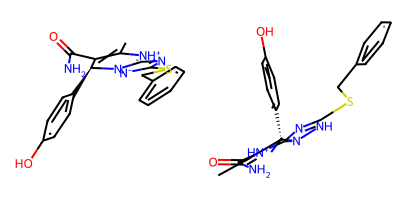

In [18]:
from rdkit.Chem import Draw

# Get the first two Mol objects from the duplicates DataFrame
mols = C04176600_Isomer1['Mol'].head(2).tolist()

# Draw the molecules side by side
img = Draw.MolsToGridImage(mols, molsPerRow=2)

img

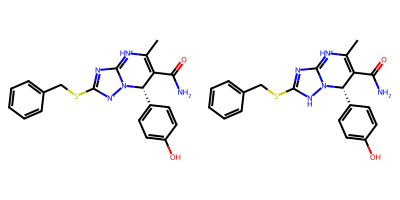

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

# Get the first two Mol objects from the duplicates DataFrame
mols = C04176600_Isomer1['Mol'].head(2).tolist()

# Calculate 2D coordinates for the molecules
for mol in mols:
  AllChem.Compute2DCoords(mol)

# Draw the molecules side by side
img = Draw.MolsToGridImage(mols, molsPerRow=2)

img

In [22]:
# Assuming C04176600_Isomer1 is your DataFrame
grouped = C04176600_Isomer1.groupby('Molecule_Name')

differences = {}

for name, group in grouped:
  diff = group.loc[:, group.nunique() > 1]
  if not diff.empty:
    differences[name] = diff

for name, diff in differences.items():
  print(f"Differences for {name}:")
  display(diff)

Differences for C04176600_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
85,<rdkit.Chem.rdchem.Mol object at 0x127227bc0>,10099,30.7602,10098,-8.99968,-0.321417,-0.976012,-2.07739,-8.99968,-3.79092,-0.0278181,-2.1832,-44.1743,-8.3662,0.504739,-0.038832,-81.3076,-52.5405,5.69805,7,281
5772,<rdkit.Chem.rdchem.Mol object at 0x2b4e200b0>,1580,38.1706,1579,-6.32902,-0.226036,-0.686379,-1.46092,-6.32902,-2.2825,-0.022477,-1.48354,-43.9732,-4.70008,0.502424,-0.139248,-72.0386,-48.6733,5.63578,1,363


In [23]:
grouped = decoy.groupby("Molecule_Name")

differences = {}

for name, group in grouped:
    diff = group.loc[:, group.nunique() > 1]
    if not diff.empty:
        differences[name] = diff

for name, diff in differences.items():
    print(f"Differences for {name}:")
    display(diff)

Differences for C00705907_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
2045,<rdkit.Chem.rdchem.Mol object at 0x2aef1d380>,3040,26.8029,3039,-7.34979,-0.282684,-0.83745,-1.72607,-7.34979,-3.3058,0,-1.85343,-45.1665,-3.48499,0.59052,0,-63.8697,-48.6515,8.26581,80,209
4291,<rdkit.Chem.rdchem.Mol object at 0x2b1f2b290>,10019,32.2104,10018,-6.67671,-0.256796,-0.760758,-1.568,-6.67671,-2.33374,-0.0148948,-1.38306,-41.1197,-9.18842,0.587587,-0.0983488,-77.4,-50.3081,0.905393,53,40


Differences for C04176600_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
85,<rdkit.Chem.rdchem.Mol object at 0x127227bc0>,10099,30.7602,10098,-8.99968,-0.321417,-0.976012,-2.07739,-8.99968,-3.79092,-0.0278181,-2.1832,-44.1743,-8.3662,0.504739,-0.038832,-81.3076,-52.5405,5.69805,7,281
5772,<rdkit.Chem.rdchem.Mol object at 0x2b4e200b0>,1580,38.1706,1579,-6.32902,-0.226036,-0.686379,-1.46092,-6.32902,-2.2825,-0.022477,-1.48354,-43.9732,-4.70008,0.502424,-0.139248,-72.0386,-48.6733,5.63578,1,363


Differences for C06009370_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
6441,<rdkit.Chem.rdchem.Mol object at 0x2b59327a0>,3608,35.4431,3607,-6.17548,-0.212947,-0.654242,-1.41403,-6.17548,-2.53196,-0.32,-1.21767,-44.9344,-4.49232,0.814719,0,-63.7507,-49.4267,7.05982,176,377
8273,<rdkit.Chem.rdchem.Mol object at 0x2b88b1070>,594,36.5635,593,-5.69402,-0.196345,-0.603235,-1.30379,-5.69402,-2.11452,-0.370345,-1.22499,-38.9809,-3.99816,0.81113,-0.246526,-61.7552,-42.9791,7.99176,139,381


Differences for C06423889_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
2325,<rdkit.Chem.rdchem.Mol object at 0x2aefa4f20>,4665,24.8219,4664,-7.24645,-0.315063,-0.895997,-1.75226,-7.24645,-2.98918,-0.32,-1.9145,-38.5027,-5.39629,0.711815,-62.1319,-43.899,3.21384,12,310
2329,<rdkit.Chem.rdchem.Mol object at 0x2aefa50e0>,2380,28.0913,2379,-7.24341,-0.314931,-0.895621,-1.75152,-7.24341,-3.09768,-0.280386,-1.89726,-38.449,-5.02373,0.707929,-67.9226,-43.4727,1.4881,51,77


Differences for C08700722_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1292,<rdkit.Chem.rdchem.Mol object at 0x2abec4740>,3430,39.7319,3429,-7.66644,-0.306658,-0.896672,-1.81718,-7.66644,-1.83745,-0.467383,-2.14841,-35.1039,-13.2398,0.70455,-0.176594,-78.1627,-48.3436,2.96415,68,208
1685,<rdkit.Chem.rdchem.Mol object at 0x2ae34f450>,3372,38.9882,3371,-7.48352,-0.299341,-0.875278,-1.77382,-7.48352,-3.42663,-0.00280095,-1.70757,-41.0731,-8.66236,1.0065,0,-73.4002,-49.7355,5.99691,20,144


Differences for C12324237_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
9001,<rdkit.Chem.rdchem.Mol object at 0x2ba40d1c0>,4812,27.125,4811,-5.46083,-0.210032,-0.622219,-1.28246,-5.46083,-2.25605,-0.0686132,-1.31276,-44.3004,-2.05673,0.781649,-0.0815279,-62.9775,-46.3572,3.1038,125,342
9604,<rdkit.Chem.rdchem.Mol object at 0x2bac1dbd0>,10361,34.8989,10360,-5.24843,-0.201863,-0.598018,-1.23258,-5.24843,-1.37245,-0.300625,-1.33373,-36.2152,-7.18834,0.778005,-0.130622,-60.7932,-43.4035,4.86072,36,264


Differences for C13121859_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
5935,<rdkit.Chem.rdchem.Mol object at 0x2b4e64890>,7208,39.8791,7207,-6.29110,-0.233004,-0.699011,-1.46446,-6.2911,-1.46593,-0.633768,-1.15921,-33.1205,-12.4936,-0.0538444,-65.0068,-45.6141,8.93528,53,194
6855,<rdkit.Chem.rdchem.Mol object at 0x2b6105e70>,7197,47.6837,7196,-6.07851,-0.22513,-0.67539,-1.41498,-6.07851,-1.66735,-0.32,-1.73948,-32.0902,-8.5189,-0.0210508,-57.2011,-40.6091,9.96272,63,171


Differences for C14156562_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1777,<rdkit.Chem.rdchem.Mol object at 0x2ae391d20>,5825,45.0727,5824,-7.44938,-0.248313,-0.771565,-1.69258,-7.44938,-2.83953,0,-1.6426,-44.9563,-9.36117,0.883847,-0.199113,-77.2332,-54.3175,12.6682,52,104
4317,<rdkit.Chem.rdchem.Mol object at 0x2b1f2bdf0>,2138,39.7756,2137,-6.67167,-0.222389,-0.691014,-1.51588,-6.67167,-1.80788,-0.32,-1.65984,-49.3978,-8.1528,0.887664,-0.0788063,-67.9518,-57.5506,20.8612,149,139


Differences for C14979644_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
464,<rdkit.Chem.rdchem.Mol object at 0x2aa8ed9a0>,5455,20.1198,5454,9,-8.26129,-0.393395,-1.08535,-2.04259,-8.26129,-2.26797,-0.484938,-1.29946,-32.5677,-21.0785,0.801329,-0.22008,-85.086,-53.6463,6.20167,130,262
1998,<rdkit.Chem.rdchem.Mol object at 0x2ae3dbe60>,11569,19.4728,11568,8,-7.36671,-0.350796,-0.967819,-1.8214,-7.36671,-2.32561,-0.192053,-1.10668,-33.4587,-17.2907,0.686853,-0.162683,-73.5679,-50.7494,12.3657,63,84


Differences for C23259756_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
291,<rdkit.Chem.rdchem.Mol object at 0x2aa8e0d60>,2998,42.9523,2997,-8.46557,-0.256532,-0.822836,-1.8827,-8.46557,-3.36221,-0.32,-1.16017,-54.2617,-10.2764,0.691707,-0.0603416,-98.2976,-64.5381,10.9211,30,86
3724,<rdkit.Chem.rdchem.Mol object at 0x2b1617840>,11445,47.1852,11444,-6.81465,-0.206505,-0.662371,-1.51554,-6.81465,-2.74819,-0.16,-0.763695,-49.7056,-7.47479,0.694345,-0.230615,-81.2381,-57.1804,3.40739,101,201


Differences for C23478984_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
4945,<rdkit.Chem.rdchem.Mol object at 0x2b3281380>,10542,30.7911,10541,-6.52181,-0.232922,-0.707287,-1.50542,-6.52181,-2.05276,-1.66149,-45.7863,-7.76402,0.670136,-0.0237732,-71.5141,-53.5503,10.6766,83,136
6723,<rdkit.Chem.rdchem.Mol object at 0x2b59be420>,10610,36.4413,10609,-6.10621,-0.218079,-0.662216,-1.40949,-6.10621,-2.13133,-1.45384,-46.4385,-5.8163,0.673328,0,-68.768,-52.2548,5.72975,17,10


Differences for C23580577_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
329,<rdkit.Chem.rdchem.Mol object at 0x2aa8e1e00>,4029,36.2908,4028,-8.41108,-0.311521,-0.934564,-1.95796,-8.41108,-3.34526,-0.167232,-1.75708,-41.2313,-11.2862,0.712986,-0.1,-87.9926,-52.5175,3.47627,155,232
2441,<rdkit.Chem.rdchem.Mol object at 0x2aefec270>,9576,37.7243,9575,-7.20929,-0.267011,-0.801032,-1.6782,-7.20929,-3.41907,0,-1.41322,-43.6308,-6.07965,0.716491,0,-72.7632,-49.7105,2.95372,82,363


Differences for C23580577_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
221,<rdkit.Chem.rdchem.Mol object at 0x2aa8dae30>,4030,36.1635,4029,-8.58907,-0.318114,-0.954341,-1.99939,-8.58907,-3.90289,-0.187131,-1.71363,-40.8158,-9.11162,0.712986,-0.0908786,-85.7881,-49.9274,3.34068,56,80
3914,<rdkit.Chem.rdchem.Mol object at 0x2b169cc80>,9577,37.85,9576,-6.76545,-0.250572,-0.751716,-1.57488,-6.76545,-2.20153,-0.210239,-1.69766,-39.4555,-9.00693,0.716491,-0.0486959,-68.7126,-48.4625,5.45491,20,42


Differences for C32576823_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1157,<rdkit.Chem.rdchem.Mol object at 0x2abe7cba0>,3000,44.6408,2999,-7.73492,-0.234392,-0.751819,-1.72021,-7.73492,-3.23939,-0.309407,-0.939377,-43.2701,-10.002,0.557439,-0.140384,-83.6502,-53.2721,9.18599,46,258
5911,<rdkit.Chem.rdchem.Mol object at 0x2b4e23d80>,11467,43.0899,11466,-6.29730,-0.190827,-0.612085,-1.40049,-6.2973,-2.75909,-0.157997,-0.919986,-50.3134,-2.80943,0.559644,-0.0827908,-71.4117,-53.1228,6.45456,75,390


Differences for C32857814_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1273,<rdkit.Chem.rdchem.Mol object at 0x2abe7fe60>,7609,40.1272,7608,-7.67583,-0.295224,-0.874601,-1.80264,-7.67583,-3.03343,-0.313393,-1.8844,-41.3858,-6.01048,0.559488,-0.0332389,-62.4973,-47.3963,9.72301,57,154
4547,<rdkit.Chem.rdchem.Mol object at 0x2b1fb23b0>,1937,41.7301,1936,-6.61929,-0.254588,-0.754216,-1.55452,-6.61929,-2.71835,-0.0484798,-1.63767,-39.113,-5.19489,0.556784,-0.0366877,-64.5972,-44.3079,3.73247,4,50


Differences for C37621622_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
4105,<rdkit.Chem.rdchem.Mol object at 0x2b16e20a0>,7861,21.4059,7860,-6.71922,-0.335961,-0.911939,-1.6816,-6.71922,-1.47286,-0.52,-2.10713,-31.9819,-13.5757,1.14126,-0.125041,-68.7359,-45.5576,6.23092,16,10
8910,<rdkit.Chem.rdchem.Mol object at 0x2b98c6960>,4980,15.7455,4979,-5.48816,-0.274408,-0.744858,-1.37351,-5.48816,-1.42873,-0.456,-2.0461,-32.2423,-7.02889,1.1484,-0.0392914,-51.4862,-39.2712,3.16254,41,133


Differences for C38994962_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1025,<rdkit.Chem.rdchem.Mol object at 0x2abe39150>,495,-3.15295,494,-7.81825,-0.289565,-0.868695,-1.81996,-7.81825,-2.67029,-0.2,-1.18088,-44.3536,-13.8696,0.607196,-0.0761577,-83.9491,-58.2233,10.4512,64,126
4295,<rdkit.Chem.rdchem.Mol object at 0x2b1f2b450>,6824,-2.73346,6823,-6.67604,-0.247261,-0.741782,-1.55407,-6.67604,-2.62087,-0.456789,-1.47765,-45.1373,-2.50512,0.609948,-0.0980459,-65.0128,-47.6424,2.9868,59,364


Differences for C40679717_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
5608,<rdkit.Chem.rdchem.Mol object at 0x2b44977d0>,1659,75.2494,1658,-6.37118,-0.193066,-0.619266,-1.41692,-6.37118,-2.62161,-0.265882,-1.06799,-52.4702,-4.14762,0.82996,0,-75.6655,-56.6178,4.5553,139,128
6235,<rdkit.Chem.rdchem.Mol object at 0x2b4eeccf0>,2790,81.7177,2789,-6.22481,-0.188631,-0.605039,-1.38437,-6.22481,-2.72677,0,-1.33248,-46.712,-4.2643,0.82651,-0.016823,-74.9517,-50.9763,2.49816,137,153


Differences for C40683734_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
2092,<rdkit.Chem.rdchem.Mol object at 0x2aef1e810>,11786,56.2691,11785,-7.32935,-0.244312,-0.759134,-1.66531,-7.32935,-2.45994,-0.873442,-1.03605,-44.8972,-9.34436,0.822056,-0.135466,-69.5344,-54.2415,17.8505,26,201
3972,<rdkit.Chem.rdchem.Mol object at 0x2b169e5e0>,861,59.8027,860,-6.74980,-0.224993,-0.699106,-1.53363,-6.7498,-2.56335,-0.214666,-1.29775,-38.5342,-9.2661,0.818418,-0.17582,-73.4567,-47.8003,5.97117,129,362


Differences for C40688690_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
7476,<rdkit.Chem.rdchem.Mol object at 0x2b7417060>,2962,46.2236,2961,-5.9111,-0.184722,-0.586455,-1.32366,-5.9111,-1.75292,-0.745305,-0.515005,-37.0814,-10.1155,0.727708,-0.254188,-59.5422,-47.1969,6.52302,38,22
8022,<rdkit.Chem.rdchem.Mol object at 0x2b882a180>,6384,54.2797,6383,-5.7706,-0.180331,-0.572516,-1.2922,-5.7706,-2.8761,-0.301161,-0.389003,-46.9557,-3.87621,0.724876,0,-65.6217,-50.8319,12.9633,192,117


Differences for C40701492_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
2004,<rdkit.Chem.rdchem.Mol object at 0x2aef1c190>,8314,73.3681,8313,-7.36307,-0.237518,-0.746135,-1.6606,-7.36307,-3.23562,-0.32,-1.29318,-41.9743,-7.11618,0.7527,-0.100824,-68.1391,-49.0905,6.95606,185,120
6768,<rdkit.Chem.rdchem.Mol object at 0x2b59bf7d0>,3014,80.7924,3013,-6.09433,-0.196591,-0.617568,-1.37446,-6.09433,-2.01526,-0.00211884,-1.51213,-44.2826,-6.4364,0.749514,-0.134757,-69.3432,-50.719,4.45069,254,313


Differences for C40709208_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
5899,<rdkit.Chem.rdchem.Mol object at 0x2b4e23840>,4215,68.7303,4214,-6.29985,-0.209995,-0.652503,-1.43139,-6.29985,-3.01589,-1.24606,-47.905,-4.2549,0.995586,-72.5595,-52.1599,6.71574,305,358
7191,<rdkit.Chem.rdchem.Mol object at 0x2b618f290>,352,76.048,351,-5.98870,-0.199623,-0.620276,-1.3607,-5.9887,-1.97046,-1.84464,-51.1394,-4.11189,1.00015,-71.074,-55.2513,6.30681,301,256


Differences for C40758269_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
4071,<rdkit.Chem.rdchem.Mol object at 0x2b16e11c0>,2288,65.3859,2287,-6.72672,-0.249138,-0.747414,-1.56587,-6.72672,-2.74953,-0.312034,-1.59977,-43.4836,-4.19485,0.753011,-0.0149927,-66.1577,-47.6785,2.8266,4,341
4449,<rdkit.Chem.rdchem.Mol object at 0x2b1f6f840>,513,67.9996,512,-6.64350,-0.246056,-0.738167,-1.5465,-6.6435,-1.70802,-0.485556,-1.89164,-36.6598,-9.12943,0.749233,-0.105116,-66.7606,-45.7893,6.70837,99,113


Differences for C40759579_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
8942,<rdkit.Chem.rdchem.Mol object at 0x2b98c7760>,8560,44.2232,8559,-5.47895,-0.195677,-0.59419,-1.2647,-5.47895,-1.62588,-0.369944,-1.00053,-37.8004,-7.94382,0.82189,-0.222904,-55.2626,-45.7442,15.4758,90,206
11249,<rdkit.Chem.rdchem.Mol object at 0x2bd3171b0>,7070,35.8384,7069,-3.86917,-0.138184,-0.41961,-0.893117,-3.86917,-1.08174,-0.32,-0.623732,-42.3811,-2.72151,0.825551,-0.141966,-46.531,-45.1026,13.3377,67,329


Differences for C43262393_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
8363,<rdkit.Chem.rdchem.Mol object at 0x2b88b37d0>,4219,22.5369,4218,-5.66317,-0.283159,-0.768611,-1.41731,-5.66317,-1.36501,-0.456,-1.36257,-31.8245,-10.5117,0.727659,-0.0392786,-56.1121,-42.3361,9.61942,15,337
10677,<rdkit.Chem.rdchem.Mol object at 0x2bc903530>,7614,28.0928,7613,-4.61237,-0.230618,-0.625995,-1.15432,-4.61237,-1.70532,-0.188025,-1.21948,-32.1523,-4.15466,0.731274,0,-42.2837,-36.307,8.3104,394,199


Differences for C45223747_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
3053,<rdkit.Chem.rdchem.Mol object at 0x2b0b01070>,4704,26.8979,4703,-7.00274,-0.437671,-1.10286,-1.85622,-7.00274,-1.30399,-0.36,-2.27736,-20.0648,-17.0809,-0.149516,-59.5365,-37.1456,3.14774,3,86
3568,<rdkit.Chem.rdchem.Mol object at 0x2b0bd3370>,4701,33.8051,4700,-6.85355,-0.428347,-1.07937,-1.81667,-6.85355,-1.73627,-0.518434,-2.34543,-27.4353,-9.73689,-0.0746191,-54.1188,-37.1722,6.70511,4,353


Differences for C53248445_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
10923,<rdkit.Chem.rdchem.Mol object at 0x2bc98a1f0>,2628,29.3798,2627,-4.35873,-0.217936,-0.59157,-1.09085,-4.35873,-1.33869,-0.158807,-2.41923,-29.2858,-7.11198,2.16917,-0.0800829,-48.0442,-36.3978,4.27789,277,29
11307,<rdkit.Chem.rdchem.Mol object at 0x2bd358ba0>,2626,39.7293,2625,-3.74586,-0.187293,-0.508391,-0.937465,-3.74586,-1.70803,-0.56879,-1.97787,-24.801,-8.78568,3.09881,-0.0320837,-40.7466,-33.5866,5.4371,119,153


Differences for C53248445_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
9978,<rdkit.Chem.rdchem.Mol object at 0x2bace8120>,2629,28.6017,2628,-5.07084,-0.253542,-0.688218,-1.26906,-5.07084,-1.47558,-0.675079,-2.29136,-26.9732,-9.06102,-0.0901686,-46.5735,-36.0342,7.78856,187,20
11185,<rdkit.Chem.rdchem.Mol object at 0x2bd3155b0>,2627,42.1512,2626,-3.96824,-0.198412,-0.538573,-0.99312,-3.96824,-0.551295,-0.576234,-2.23197,-26.5151,-9.01442,-0.1,-44.8285,-35.5295,6.66799,95,365


Differences for C53633297_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1712,<rdkit.Chem.rdchem.Mol object at 0x2ae3900b0>,6395,22.7658,6394,-7.47368,-0.213534,-0.698483,-1.64064,-7.47368,-3.00072,-0.259408,-1.13835,-52.8168,-6.27783,0.639937,-0.132623,-89.4866,-59.0947,9.74942,211,330
2445,<rdkit.Chem.rdchem.Mol object at 0x2aefec430>,9027,18.732,9026,-7.20674,-0.205907,-0.673535,-1.58204,-7.20674,-2.86464,-0.217975,-1.26076,-54.3537,-4.33521,0.642284,-0.137675,-77.7224,-58.6889,9.83941,124,353


Differences for C53860104_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
8303,<rdkit.Chem.rdchem.Mol object at 0x2b88b1d90>,4340,28.3941,4339,-5.68005,-0.270479,-0.74623,-1.40438,-5.68005,-1.76355,-0.52,-1.86173,-19.6684,-10.0551,-0.0789778,-38.3349,-29.7234,9.42504,135,348
9852,<rdkit.Chem.rdchem.Mol object at 0x2baca4970>,4341,36.7309,4340,-5.13226,-0.244393,-0.674262,-1.26894,-5.13226,-1.75909,-0.470781,-1.42713,-25.1351,-8.3626,0,-44.8367,-33.4977,8.43895,64,160


Differences for C57531393_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
6127,<rdkit.Chem.rdchem.Mol object at 0x2b4ea9d20>,1666,28.267,1665,8,-6.24930,-0.20831,-0.647268,-1.41991,-6.2493,-1.27497,-0.36,-1.2574,-47.1995,-7.80321,0.38264,-0.209116,-79.9646,-55.0028,4.55696,4,154
9483,<rdkit.Chem.rdchem.Mol object at 0x2ba4da650>,136,41.7202,135,7,-5.29055,-0.176352,-0.547966,-1.20207,-5.29055,-1.27887,-0.2,-1.40867,-47.6985,-2.08606,0.384176,-0.0893601,-64.4883,-49.7845,6.50553,2,384


Differences for C57531397_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
10216,<rdkit.Chem.rdchem.Mol object at 0x2bbc329d0>,1811,43.0464,1810,7,-4.95384,-0.165128,-0.513091,-1.12557,-4.95384,-1.12649,-0.196552,-1.49517,-48.7102,-0.0399416,-0.0782951,-60.5962,-48.7501,10.0627,6,195
10594,<rdkit.Chem.rdchem.Mol object at 0x2bc9010e0>,87,27.8351,86,8,-4.68794,-0.156265,-0.48555,-1.06515,-4.68794,-1.78563,0,-1.00228,-31.438,-3.84714,-0.135236,-36.9158,-35.2851,12.4699,1,18


Differences for C61904531_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1260,<rdkit.Chem.rdchem.Mol object at 0x2abe7f8b0>,9662,26.5686,9661,-7.68089,-0.295419,-0.875178,-1.80383,-7.68089,-1.90343,-0.2,-2.6705,-39.286,-10.3473,0.670299,-0.0608633,-78.8711,-49.6333,3.00002,34,277
6033,<rdkit.Chem.rdchem.Mol object at 0x2b4e67370>,11118,29.1397,11117,-6.26959,-0.241138,-0.71437,-1.47239,-6.26959,-2.02666,-0.189927,-1.88722,-45.2259,-3.85316,0.673493,0,-63.8539,-49.0791,7.8458,60,259


Differences for C61907774_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1991,<rdkit.Chem.rdchem.Mol object at 0x2ae3dbb50>,10608,40.2264,10607,-7.36870,-0.254093,-0.780655,-1.68725,-7.3687,-2.57539,-0.437283,-2.11516,-46.943,-6.33554,1.05662,0,-73.0496,-53.2785,10.6829,274,353
4487,<rdkit.Chem.rdchem.Mol object at 0x2b1fb0970>,6393,40.2328,6392,-6.63452,-0.228776,-0.702874,-1.51914,-6.63452,-2.66082,0,-1.28314,-52.2857,-7.29074,1.05194,-0.034603,-79.6967,-59.5764,9.69735,162,177


Differences for C61930978_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
551,<rdkit.Chem.rdchem.Mol object at 0x2aa8f8040>,523,33.243,522,-8.17929,-0.292117,-0.88704,-1.88802,-8.17929,-2.939,-0.52,-1.50997,-49.0051,-9.52931,0.806272,-0.136942,-92.2175,-58.5344,6.20562,87,303
2230,<rdkit.Chem.rdchem.Mol object at 0x2aef62500>,3694,39.732,3693,-7.27800,-0.259928,-0.789296,-1.67997,-7.278,-2.94291,-0.32,-1.53399,-52.5307,-4.11652,0.809828,-0.0469064,-78.5735,-56.6472,5.48334,183,173


Differences for C66726581_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
3078,<rdkit.Chem.rdchem.Mol object at 0x2b0b01b60>,1454,48.2736,1453,-6.99284,-0.258994,-0.776983,-1.62782,-6.99284,-2.3137,-0.00642735,-1.71724,-44.4944,-10.7064,0.911942,-0.0367363,-81.8792,-55.2009,3.43078,160,44
4244,<rdkit.Chem.rdchem.Mol object at 0x2b1f29e00>,2506,50.1395,2505,-6.68795,-0.247702,-0.743106,-1.55685,-6.68795,-2.09601,-0.476136,-1.47669,-43.1661,-8.81514,0.916225,-0.0747682,-70.5978,-51.9813,4.22171,244,160


Differences for C67696293_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
3153,<rdkit.Chem.rdchem.Mol object at 0x2b0b03c30>,6604,63.5249,6603,-6.96976,-0.268068,-0.79415,-1.63683,-6.96976,-2.53906,-0.0480153,-1.51032,-28.156,-14.9089,0.859713,-0.0879465,-62.816,-43.0648,8.34008,376,180
10616,<rdkit.Chem.rdchem.Mol object at 0x2bc901a80>,5879,64.0358,5878,-4.66953,-0.179597,-0.532056,-1.09662,-4.66953,-1.85427,0,-1.46683,-34.3325,-2.8478,0.86395,-0.0685792,-47.2254,-37.1803,4.03942,33,19


Differences for C71307192_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
4976,<rdkit.Chem.rdchem.Mol object at 0x2b3282110>,5335,27.6872,5334,-6.51117,-0.325559,-0.883702,-1.62953,-6.51117,-2.02608,-0.36,-1.38607,-33.7236,-10.8186,0.738761,-0.16882,-66.6813,-44.5422,2.61788,3,87
8361,<rdkit.Chem.rdchem.Mol object at 0x2b88b36f0>,11294,27.3177,11293,-5.66385,-0.283192,-0.768703,-1.41747,-5.66385,-1.80288,-0.304,-1.39294,-34.3352,-6.64798,0.74246,-0.192529,-54.2772,-40.9832,2.52987,72,277


Differences for C72432763_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
6729,<rdkit.Chem.rdchem.Mol object at 0x2b59be6c0>,10846,46.5902,10845,-6.10514,-0.254381,-0.733761,-1.46124,-6.10514,-0.910406,-0.504415,-1.56071,-24.834,-16.6576,-0.227739,-63.1283,-41.4916,7.57583,26,151
7728,<rdkit.Chem.rdchem.Mol object at 0x2b749dfc0>,10848,56.7489,10847,-5.84813,-0.243672,-0.702872,-1.39973,-5.84813,-1.28567,-0.326479,-1.66637,-26.6986,-12.9393,-0.132249,-56.8738,-39.6379,12.0469,154,299


Differences for C72432763_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
7385,<rdkit.Chem.rdchem.Mol object at 0x2b7414890>,10847,46.4938,10846,-5.93576,-0.247323,-0.713404,-1.4207,-5.93576,-0.923325,-0.18686,-2.2368,-26.2074,-11.3779,-0.158642,-59.2874,-37.5854,2.79986,2,28
7591,<rdkit.Chem.rdchem.Mol object at 0x2b745a340>,10849,46.6311,10848,-5.87972,-0.244988,-0.706668,-1.40729,-5.87972,-0.914031,-0.158977,-2.22805,-26.0491,-11.4432,-0.146658,-58.8009,-37.4922,3.04493,12,56


Differences for C74626897_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
2273,<rdkit.Chem.rdchem.Mol object at 0x2aef637d0>,9607,23.2877,9606,-7.26387,-0.27938,-0.827661,-1.7059,-7.26387,-2.81183,-0.616436,-1.45223,-45.2615,-7.10625,-0.189675,-74.7385,-52.3677,2.33878,114,72
5667,<rdkit.Chem.rdchem.Mol object at 0x2b44dd230>,2745,17.63,2744,-6.35854,-0.244559,-0.724506,-1.49328,-6.35854,-2.2868,-0.532732,-1.35721,-45.5389,-6.64189,-0.0438815,-69.7308,-52.1808,3.88151,73,343


Differences for C78581363_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
6653,<rdkit.Chem.rdchem.Mol object at 0x2b59bc580>,7247,35.8736,7246,-6.12425,-0.235548,-0.69781,-1.43826,-6.12425,-1.52809,-0.864,-1.27161,-38.9012,-12.9082,-0.0335716,-72.94,-51.8094,4.17999,143,313
6960,<rdkit.Chem.rdchem.Mol object at 0x2b6148cf0>,7246,35.5375,7245,-6.04464,-0.232486,-0.688739,-1.41956,-6.04464,-1.49031,-0.509406,-1.36359,-38.1492,-14.1146,-0.110989,-76.0469,-52.2638,2.66238,297,386


Differences for C78666624_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
1265,<rdkit.Chem.rdchem.Mol object at 0x2abe7fae0>,11648,47.4664,11647,-7.67926,-0.255975,-0.795375,-1.74481,-7.67926,-2.98722,-0.245633,-1.20083,-47.0956,-9.19575,0.541487,-0.0529246,-82.2524,-56.2914,5.18785,1,183
1555,<rdkit.Chem.rdchem.Mol object at 0x2ae30bae0>,485,44.9747,484,-7.53493,-0.251164,-0.780426,-1.71202,-7.53493,-2.87799,-0.497607,-1.00009,-46.8659,-8.63905,0.543598,-0.0636926,-72.9955,-55.505,9.72445,14,63


Differences for C79077325_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum
11531,<rdkit.Chem.rdchem.Mol object at 0x2bd39ee30>,5057,19.7217,5056,10,-3.11680,-0.15584,-0.423015,-0.780032,-3.1168,-2.11185,-0.205287,-1.99105,-32.1992,-4.72496,3.60803,-0.0979336,-40.3741,-36.9242,8.37072,98,156
11594,<rdkit.Chem.rdchem.Mol object at 0x2bd3e0a50>,5021,10.6567,5020,11,-2.62517,-0.131259,-0.356291,-0.656994,-2.62517,-1.33021,-0.152553,-2.2429,-29.2673,-9.22144,4.03404,-0.0869765,-43.6814,-38.4887,2.96052,199,324


Basically, we need to drop the duplicates before we make the strain calculation. Why we get two outputs? I don't know. The LigPrep sdf was made as Schrodinger suggested. We can look at it. 

In [25]:
def ligprep_sdf_to_df(args):
    """
    TEMPORARY FUNCTION FOR LIGPREP DUPLICATE CHECK 

    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    return df

In [26]:
ligprep_decoy = ligprep_sdf_to_df(("/Users/lkv206/work/to_do_projects/chembl_ligands/GPCR-Bench-master/5HT1B/stereochemistry/5HT1B_chembl19_set_decoy.sdf", "inactive"))
ligprep_decoy

[13:41:22] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:41:22] Warning: molecule is tagged as 3D, but all Z coords are zero


,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant
0,C01425826_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ce0ca260>,0,5HT1B_chembl19_set_decoy_sc.smi,3,53161,0,S-OPLS,33.067,1,C01425826_Isomer1-1
1,C02397495_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ce0ca1f0>,0,5HT1B_chembl19_set_decoy_sc.smi,2,53161,0,S-OPLS,31.7209,1,C02397495_Isomer1-1
2,C05274703_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ce0c9ee0>,0,5HT1B_chembl19_set_decoy_sc.smi,4,53161,0,S-OPLS,46.4002,1,C05274703_Isomer1-1
3,C05274703_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x2ce0ca500>,0,5HT1B_chembl19_set_decoy_sc.smi,5,53161,0,S-OPLS,48.1125,1,C05274703_Isomer2-1
4,C05868819_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ce0ca570>,0,5HT1B_chembl19_set_decoy_sc.smi,6,53161,0,S-OPLS,10.5879,1,C05868819_Isomer1-1
...,...,...,...,...,...,...,...,...,...,...,...
14462,C32068914_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2e1b391c0>,0,5HT1B_chembl19_set_decoy_sc.smi,14465,53161,0,S-OPLS,25.0595,1,C32068914_Isomer1-1
14463,C75264699_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2e1b39230>,0,5HT1B_chembl19_set_decoy_sc.smi,14464,53161,0,S-OPLS,17.5038,1,C75264699_Isomer1-1
14464,C77455063_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2e1b392a0>,0,5HT1B_chembl19_set_decoy_sc.smi,14466,53161,0,S-OPLS,21.041,1,C77455063_Isomer1-1
14465,C78525172_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2e1b39310>,0,5HT1B_chembl19_set_decoy_sc.smi,14467,53161,0,S-OPLS,24.3369,1,C78525172_Isomer1-1


In [29]:
grouped = ligprep_decoy.groupby('Molecule_Name')

differences = {}

for name, group in grouped:
    diff = group.loc[:, group.nunique() > 1]
    if not diff.empty:
        differences[name] = diff

for name, diff in differences.items():
    print(f"Differences for {name}:")
    display(diff)

Differences for C01204348_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
5370,<rdkit.Chem.rdchem.Mol object at 0x2d3cc2420>,5372,34.9004
5430,<rdkit.Chem.rdchem.Mol object at 0x2d3cc3e60>,5432,39.2653


Differences for C01204348_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy
5371,<rdkit.Chem.rdchem.Mol object at 0x2d3cc2490>,5373,38.6149
5431,<rdkit.Chem.rdchem.Mol object at 0x2d3cc3ed0>,5433,42.6744


Differences for C04967479_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
2581,<rdkit.Chem.rdchem.Mol object at 0x2d1701700>,2583,105.532
10158,<rdkit.Chem.rdchem.Mol object at 0x2dc6b6650>,10160,94.6351


Differences for C05499211_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
3602,<rdkit.Chem.rdchem.Mol object at 0x2d17f57e0>,3604,34.3027
3604,<rdkit.Chem.rdchem.Mol object at 0x2d17f58c0>,3606,33.2208


Differences for C05499211_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy
3603,<rdkit.Chem.rdchem.Mol object at 0x2d17f5850>,3605,33.1283
3605,<rdkit.Chem.rdchem.Mol object at 0x2d17f5930>,3607,31.7139


Differences for C08413261_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4751,<rdkit.Chem.rdchem.Mol object at 0x2d3c29310>,4753,38.3604
4753,<rdkit.Chem.rdchem.Mol object at 0x2d3c293f0>,4755,38.6466


Differences for C08413263_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4754,<rdkit.Chem.rdchem.Mol object at 0x2d3c29460>,4756,40.8657
4758,<rdkit.Chem.rdchem.Mol object at 0x2d3c29620>,4760,38.647


Differences for C08913119_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
6106,<rdkit.Chem.rdchem.Mol object at 0x2d4f868f0>,6108,38.6694
7618,<rdkit.Chem.rdchem.Mol object at 0x2d89284a0>,7620,48.542


Differences for C09402241_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
9442,<rdkit.Chem.rdchem.Mol object at 0x2d9cf6a40>,9444,64.337
9491,<rdkit.Chem.rdchem.Mol object at 0x2dc61c040>,9493,70.0093


Differences for C09545561_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
9443,<rdkit.Chem.rdchem.Mol object at 0x2d9cf6ab0>,9445,40.5351
10927,<rdkit.Chem.rdchem.Mol object at 0x2dd973990>,10930,53.1623


Differences for C15072750_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
6947,<rdkit.Chem.rdchem.Mol object at 0x2d7869c40>,6949,27.6107
7006,<rdkit.Chem.rdchem.Mol object at 0x2d786b610>,7007,29.2298


Differences for C18325275_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
3714,<rdkit.Chem.rdchem.Mol object at 0x2d2b1c970>,3718,30.645
3715,<rdkit.Chem.rdchem.Mol object at 0x2d2b1c9e0>,3720,34.4525


Differences for C19294212_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
3743,<rdkit.Chem.rdchem.Mol object at 0x2d2b1d620>,3745,42.1064
7737,<rdkit.Chem.rdchem.Mol object at 0x2d892b8b0>,7739,23.7005


Differences for C19373054_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4478,<rdkit.Chem.rdchem.Mol object at 0x2d2bdda80>,4480,57.9923
7800,<rdkit.Chem.rdchem.Mol object at 0x2d89514d0>,7802,68.907


Differences for C19373054_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy
4480,<rdkit.Chem.rdchem.Mol object at 0x2d2bddb60>,4481,64.9605
7801,<rdkit.Chem.rdchem.Mol object at 0x2d8951540>,7803,67.0097


Differences for C20113780_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
8823,<rdkit.Chem.rdchem.Mol object at 0x2d9c5d930>,8825,67.645
8827,<rdkit.Chem.rdchem.Mol object at 0x2d9c5daf0>,8827,63.5906


Differences for C20192801_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4880,<rdkit.Chem.rdchem.Mol object at 0x2d3c50c10>,4881,75.9457
5288,<rdkit.Chem.rdchem.Mol object at 0x2d3cc0040>,5290,70.5246


Differences for C22009953_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
1282,<rdkit.Chem.rdchem.Mol object at 0x2cf4a99a0>,1284,62.1277
1346,<rdkit.Chem.rdchem.Mol object at 0x2cf4ab5a0>,1348,55.1535


Differences for C22854073_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
2592,<rdkit.Chem.rdchem.Mol object at 0x2d1701bd0>,2594,23.6229
2642,<rdkit.Chem.rdchem.Mol object at 0x2d17031b0>,2645,19.7681


Differences for C25159316_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
8051,<rdkit.Chem.rdchem.Mol object at 0x2d89983c0>,8053,32.4187
8111,<rdkit.Chem.rdchem.Mol object at 0x2d8999e00>,8113,27.7813


Differences for C31935043_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
7225,<rdkit.Chem.rdchem.Mol object at 0x2d78b5700>,7227,38.099
9734,<rdkit.Chem.rdchem.Mol object at 0x2dc642b20>,9736,45.6781


Differences for C32510945_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
617,<rdkit.Chem.rdchem.Mol object at 0x2ce3eb3e0>,619,44.9375
621,<rdkit.Chem.rdchem.Mol object at 0x2ce3eb5a0>,618,55.6015


Differences for C33374600_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
2931,<rdkit.Chem.rdchem.Mol object at 0x2d1753140>,2932,86.1334
2932,<rdkit.Chem.rdchem.Mol object at 0x2d17531b0>,2933,90.9541


Differences for C36790321_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
315,<rdkit.Chem.rdchem.Mol object at 0x2ce3a6ea0>,315,35.8378
319,<rdkit.Chem.rdchem.Mol object at 0x2ce3a7060>,316,35.7273


Differences for C39980367_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
2957,<rdkit.Chem.rdchem.Mol object at 0x2d1753ca0>,2956,74.2126
8607,<rdkit.Chem.rdchem.Mol object at 0x2d9c0f990>,8611,72.9892


Differences for C42438624_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4693,<rdkit.Chem.rdchem.Mol object at 0x2d3c03920>,4695,52.6573
14032,<rdkit.Chem.rdchem.Mol object at 0x2e0ac13f0>,14034,53.4489


Differences for C48992487_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
781,<rdkit.Chem.rdchem.Mol object at 0x2cf40fc30>,784,30.6022
784,<rdkit.Chem.rdchem.Mol object at 0x2cf40fd80>,785,34.7871


Differences for C53327147_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
8078,<rdkit.Chem.rdchem.Mol object at 0x2d8998f90>,8080,37.6865
8127,<rdkit.Chem.rdchem.Mol object at 0x2d899a500>,8129,27.0773


Differences for C61819528_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
11180,<rdkit.Chem.rdchem.Mol object at 0x2dd9c6960>,11182,51.6803
11181,<rdkit.Chem.rdchem.Mol object at 0x2dd9c69d0>,11183,38.7915


Differences for C61974401_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
9479,<rdkit.Chem.rdchem.Mol object at 0x2d9cf7a70>,9481,28.3824
10955,<rdkit.Chem.rdchem.Mol object at 0x2dd998660>,10958,33.1609


Differences for C63743510_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
519,<rdkit.Chem.rdchem.Mol object at 0x2ce3e8900>,523,31.7799
7666,<rdkit.Chem.rdchem.Mol object at 0x2d89299a0>,7668,35.7089


Differences for C64053315_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
3169,<rdkit.Chem.rdchem.Mol object at 0x2d179da80>,3170,46.3381
7840,<rdkit.Chem.rdchem.Mol object at 0x2d8952650>,7842,53.2454


Differences for C64137266_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
13722,<rdkit.Chem.rdchem.Mol object at 0x2e0a74b30>,13724,73.9416
13798,<rdkit.Chem.rdchem.Mol object at 0x2e0a76c70>,13800,61.72


Differences for C64609567_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
1586,<rdkit.Chem.rdchem.Mol object at 0x2cf4f1fc0>,1588,49.2965
13725,<rdkit.Chem.rdchem.Mol object at 0x2e0a74c80>,13727,47.2694


Differences for C71912021_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
12946,<rdkit.Chem.rdchem.Mol object at 0x2df88f4c0>,12948,27.8296
12947,<rdkit.Chem.rdchem.Mol object at 0x2df88f530>,12949,20.4384


Differences for C72254962_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
9067,<rdkit.Chem.rdchem.Mol object at 0x2d9ca8510>,9068,26.3127
9126,<rdkit.Chem.rdchem.Mol object at 0x2d9ca9ee0>,9128,26.5578


Differences for C72427193_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
4844,<rdkit.Chem.rdchem.Mol object at 0x2d3c2bbc0>,4844,18.8392
7258,<rdkit.Chem.rdchem.Mol object at 0x2d78b6570>,7260,16.5153


Differences for C72453961_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
8932,<rdkit.Chem.rdchem.Mol object at 0x2d9c84970>,8934,48.2141
8933,<rdkit.Chem.rdchem.Mol object at 0x2d9c849e0>,8935,43.3992


Differences for C74767399_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
248,<rdkit.Chem.rdchem.Mol object at 0x2ce3a5150>,250,40.9828
249,<rdkit.Chem.rdchem.Mol object at 0x2ce3a51c0>,251,46.0821


Differences for C76048059_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
11127,<rdkit.Chem.rdchem.Mol object at 0x2dd9c5230>,11129,27.807
11129,<rdkit.Chem.rdchem.Mol object at 0x2dd9c5310>,11131,23.5529


Differences for C76048059_Isomer2:


,Mol,i_m_source_file_index,r_lp_Energy
11128,<rdkit.Chem.rdchem.Mol object at 0x2dd9c52a0>,11130,27.0677
11130,<rdkit.Chem.rdchem.Mol object at 0x2dd9c5380>,11132,22.9449


Differences for C76930938_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
13428,<rdkit.Chem.rdchem.Mol object at 0x2e0a2c970>,13430,63.9212
13431,<rdkit.Chem.rdchem.Mol object at 0x2e0a2cac0>,13433,47.8382


Differences for C77189296_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
5598,<rdkit.Chem.rdchem.Mol object at 0x2d4f10900>,5599,23.631
5649,<rdkit.Chem.rdchem.Mol object at 0x2d4f11f50>,5652,23.6479


Differences for C77476575_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
3204,<rdkit.Chem.rdchem.Mol object at 0x2d179e9d0>,3201,25.3108
3248,<rdkit.Chem.rdchem.Mol object at 0x2d179fd10>,3250,18.6946


Differences for C77634154_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
11135,<rdkit.Chem.rdchem.Mol object at 0x2dd9c55b0>,11137,34.0139
11136,<rdkit.Chem.rdchem.Mol object at 0x2dd9c5620>,11138,38.7956


Differences for C78551030_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
2966,<rdkit.Chem.rdchem.Mol object at 0x2d1774120>,2969,55.7195
7676,<rdkit.Chem.rdchem.Mol object at 0x2d8929e00>,7677,62.1516


Differences for C78952673_Isomer1:


,Mol,i_m_source_file_index,r_lp_Energy
12198,<rdkit.Chem.rdchem.Mol object at 0x2de9d2ab0>,12199,23.4453
12253,<rdkit.Chem.rdchem.Mol object at 0x2de9f8350>,12255,26.8241


In [32]:
# Find duplicates in 'Molecule_Name' in ligprep_decoy
ligprep_decoy_duplicates = ligprep_decoy[ligprep_decoy.duplicated('Molecule_Name', keep=False)]

# Find these duplicates in decoy
decoy_duplicates = decoy[decoy['Molecule_Name'].isin(ligprep_decoy_duplicates['Molecule_Name'])]

display(decoy_duplicates)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty


In [34]:
# Find duplicates in 'Molecule_Name' in ligprep_decoy
ligprep_decoy_duplicates = ligprep_decoy[ligprep_decoy.duplicated('Molecule_Name', keep=False)]

# Find duplicates in 'Molecule_Name' in decoy
decoy_duplicates = decoy[decoy.duplicated('Molecule_Name', keep=False)]

# Display the 'Molecule_Name' column of the duplicates
print("Duplicate Molecule Names in ligprep_decoy:")
print(ligprep_decoy_duplicates['Molecule_Name'])

print("\nDuplicate Molecule Names in decoy:")
print(decoy_duplicates['Molecule_Name'])

Duplicate Molecule Names in ligprep_decoy:
248      C74767399_Isomer1
249      C74767399_Isomer1
315      C36790321_Isomer1
319      C36790321_Isomer1
519      C63743510_Isomer1
               ...        
13431    C76930938_Isomer1
13722    C64137266_Isomer1
13725    C64609567_Isomer1
13798    C64137266_Isomer1
14032    C42438624_Isomer1
Name: Molecule_Name, Length: 94, dtype: object

Duplicate Molecule Names in decoy:
85       C04176600_Isomer1
221      C23580577_Isomer2
291      C23259756_Isomer1
329      C23580577_Isomer1
464      C14979644_Isomer1
               ...        
11185    C53248445_Isomer2
11249    C40759579_Isomer1
11307    C53248445_Isomer1
11531    C79077325_Isomer1
11594    C79077325_Isomer1
Name: Molecule_Name, Length: 88, dtype: object


In [35]:
# Check if a duplicate 'Molecule_Name' in ligprep_decoy exists in decoy
ligprep_in_decoy = ligprep_decoy_duplicates['Molecule_Name'].isin(decoy['Molecule_Name'])

# Check if a duplicate 'Molecule_Name' in decoy exists in ligprep_decoy
decoy_in_ligprep = decoy_duplicates['Molecule_Name'].isin(ligprep_decoy['Molecule_Name'])

# Display the results
print("Duplicate 'Molecule_Name' in ligprep_decoy that exists in decoy:")
print(ligprep_decoy_duplicates['Molecule_Name'][ligprep_in_decoy])

print("\nDuplicate 'Molecule_Name' in decoy that exists in ligprep_decoy:")
print(decoy_duplicates['Molecule_Name'][decoy_in_ligprep])

Duplicate 'Molecule_Name' in ligprep_decoy that exists in decoy:
Series([], Name: Molecule_Name, dtype: object)

Duplicate 'Molecule_Name' in decoy that exists in ligprep_decoy:
Series([], Name: Molecule_Name, dtype: object)


Seems like the duplicates pop up out of their own accord here and are not even shared. 

Either way, let's just drop them from the sdf. 

How do we do that? There's Glide sort. In the future we should fix the docking pipeline. 

```sh
$SCHRODINGER/utilities/glide_sort -o OUTPUT_FILE -use_dscore -best_by_title FILE1 FILE2 FILE3 ...
```

we can try it on a test case 

```sh
$SCHRODINGER/utilities/glide_sort -o sort_5HT1B_decoy_docking_lib.sdf -use_dscore -best_by_title 5HT1B_decoy_docking_lib.sdf

grep '\$\$\$\$' sort_5HT1B_decoy_docking_lib.sdf | wc -l
14282

grep '\$\$\$\$' 5HT1B_decoy_docking_lib.sdf | wc -l
14329
```

47 removed duplicates. let's see it here. oh damn it wrong one. 

In [37]:
decoy = sdf_to_df(("./5HT1B/docking/5HT1B_decoy_docking_lib.sdf", "inactive"))
print(f"Shape of decoy: {decoy.shape}")
sorted_decoy = sdf_to_df(("./5HT1B/docking/sort_5HT1B_decoy_docking_lib.sdf", "inactive"))
print(f"Shape of sorted_decoy: {sorted_decoy.shape}")

Shape of decoy: (14329, 33)
Shape of sorted_decoy: (14282, 33)


Well, great, they agree. We need to implement this but that is gonna be extremely non-trivial as it also changes our strain_runner system. That sucks. 

If we can do the sort, we might be able to update this part in `strain_runner.sh` to use a different f command for '*_lib_sorted.sdf'?  

```sh
# Generate and execute commands
find "$BASE_DIR" -type f -name "*_lib.sdf" -exec readlink -f {} \; | while read -r file_path; do
    output_path=$(echo "$file_path" | sed "s|/docking/|/strain/|" | sed "s|.sdf$|.csv|")
    cmd="python $SCRIPT -i \"$file_path\" -o \"$output_path\""
    echo "$cmd"
done | parallel --dry-run
```

Maybe we can automate glide_sort with abs paths? 

Does our script have other issues related to the data? 

I don't really think so. 

Either way, we will need a `glide_sort_runner.sh` script and then `sorted_strain_runner.sh` script. 

$SCHRODINGER/utilities/glide_sort -o OUTPUT_FILE -use_dscore -best_by_title INPUT_FILE

I need to write a script that can execute the following command in parallel by finding the INPUT_FILE based on my specifications, and then writing my OUTPUT_FILE dynamically based on my logic. The script must first echo the command to be run via `parallel` using a dry run option, like --dry-run. Then, the script will allow me to inspect the results and if it is correct, I can confirm execution. I can provide an example of this later. Both arguments in the command must use absolute paths, this will involve converting the INPUT_FILE from a relative path to my pwd to an absolute path. This is because finding the paths requires me run the desired find command from my pwd.

Within my pwd, I can run: 

find . -type f -name "*_lib.sdf"

To find the relative path of the desired INPUT_FILE, here are some non-exhaustive sample inputs: 

./ADRB1/docking/ADRB1_decoy_docking_lib.sdf
./ADRB1/docking/ADRB1_active_docking_lib.sdf

I will want to make the output replace the '_lib.sdf' extension with '_lib_sorted.sdf', but otherwise keep the identical path structure. 

So one example command would look like 

$SCHRODINGER/utilities/glide_sort -o absolute/path/to/input-prefix_lib_sorted.sdf -use_dscore -best_by_title INPUT_FILE

In a similar, BUT NOT IDENTICAL, situation (the output directory also had to change in this, absolute paths were also likely not defined, used with a different command) we used this:


```sh
# Generate and execute commands
find "$BASE_DIR" -type f -name "*_lib.sdf" -exec readlink -f {} \; | while read -r file_path; do
    output_path=$(echo "$file_path" | sed "s|/docking/|/strain/|" | sed "s|.sdf$|.csv|")
    cmd="python $SCRIPT -i \"$file_path\" -o \"$output_path\""
    echo "$cmd"
done | parallel --dry-run

# Ask for confirmation to proceed with actual execution
read -p "Proceed with execution? (y/n): " confirm && [[ $confirm == [yY] ]] || exit 1

# If confirmed, execute the commands
echo "Executing commands..."
find "$BASE_DIR" -type f -name "*_lib.sdf" -exec readlink -f {} \; | while read -r file_path; do
    output_path=$(echo "$file_path" | sed "s|/docking/|/strain/|" | sed "s|.sdf$|.csv|")
    cmd="python $SCRIPT -i \"$file_path\" -o \"$output_path\""
    echo "$cmd"
done | parallel
```
Let's think step by step.


That worked pretty quickly. We now have the sorted docked sdfs. We then also have the correct strains as well. It is time to check them. Once they finish running. 

Let's move to a clean notebook. 